In [53]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = os.path.join("/home/licongcong/Desktop/learning/gse_project/scan2food/model/train")
test_dir = os.path.join("/home/licongcong/Desktop/learning/gse_project/scan2food/model/test")

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3

# Display a sample
print(f"Classes: {train_dataset.class_to_idx}")
# img, category, nutri = dataset[0]
# print("Category ID:", category)
# print("Nutri-score label:", nutri)
# print("Image Tensor Shape:", img.shape)

# Use the default pretrained weights

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.class_to_idx))  # categories

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

EPOCHS = 20
# History for plotting
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        _, preds = torch.max(outputs, 1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

    train_loss = total_loss / total_samples if total_samples > 0 else 0
    train_acc = total_correct / total_samples if total_samples > 0 else 0

    # Validation / Test evaluation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            batch_size = images.size(0)
            val_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_samples += batch_size

    val_loss = val_loss / val_samples if val_samples > 0 else 0
    val_acc = val_correct / val_samples if val_samples > 0 else 0

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # Record history for plotting
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)



Classes: {'Mi Gorenge noodle': 0, 'banana': 1, 'dragon_fruit': 2, 'guava': 3, 'mangos': 4, 'papaya': 5, 'pineapple': 6, 'pomelo': 7, 'wasabi peas': 8}


/home/licongcong/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/licongcong/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20] Train Loss: 2.2308 Train Acc: 0.2058 | Val Loss: 1.8906 Val Acc: 0.3443
Epoch [2/20] Train Loss: 1.6319 Train Acc: 0.5036 | Val Loss: 1.4422 Val Acc: 0.6164
Epoch [3/20] Train Loss: 1.2875 Train Acc: 0.6590 | Val Loss: 1.1510 Val Acc: 0.7180
Epoch [4/20] Train Loss: 1.0446 Train Acc: 0.7353 | Val Loss: 0.9930 Val Acc: 0.7279
Epoch [5/20] Train Loss: 0.9138 Train Acc: 0.7712 | Val Loss: 0.8898 Val Acc: 0.7672
Epoch [6/20] Train Loss: 0.8064 Train Acc: 0.8058 | Val Loss: 0.8081 Val Acc: 0.7705
Epoch [7/20] Train Loss: 0.7310 Train Acc: 0.8216 | Val Loss: 0.7554 Val Acc: 0.7902
Epoch [8/20] Train Loss: 0.6757 Train Acc: 0.8345 | Val Loss: 0.7187 Val Acc: 0.8000
Epoch [9/20] Train Loss: 0.6358 Train Acc: 0.8460 | Val Loss: 0.6856 Val Acc: 0.7902
Epoch [10/20] Train Loss: 0.5766 Train Acc: 0.8676 | Val Loss: 0.6597 Val Acc: 0.8066
Epoch [11/20] Train Loss: 0.5525 Train Acc: 0.8705 | Val Loss: 0.6363 Val Acc: 0.8066
Epoch [12/20] Train Loss: 0.5147 Train Acc: 0.8806 | Val Loss: 

In [54]:
MODEL_PATH = "food_resnet18.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Trained model saved to {MODEL_PATH}")

# Plot training curves (loss & accuracy)
# Summary: print min/max for train and test (validation) loss and accuracy
if train_loss_history:
    print(f"Train Loss: min {min(train_loss_history):.4f} | max {max(train_loss_history):.4f}")
else:
    print("Train Loss: no history available")

if val_loss_history:
    print(f"Test Loss: min {min(val_loss_history):.4f} | max {max(val_loss_history):.4f}")
else:
    print("Test Loss: no history available")

if train_acc_history:
    print(f"Train Acc : min {min(train_acc_history):.4f} | max {max(train_acc_history):.4f}")
else:
    print("Train Acc: no history available")

if val_acc_history:
    print(f"Test Acc : min {min(val_acc_history):.4f} | max {max(val_acc_history):.4f}")
else:
    print("Test Acc: no history available")

Trained model saved to food_resnet18.pth
Train Loss: min 0.2926 | max 2.2308
Test Loss: min 0.5273 | max 1.8906
Train Acc : min 0.2058 | max 0.9568
Test Acc : min 0.3443 | max 0.8459


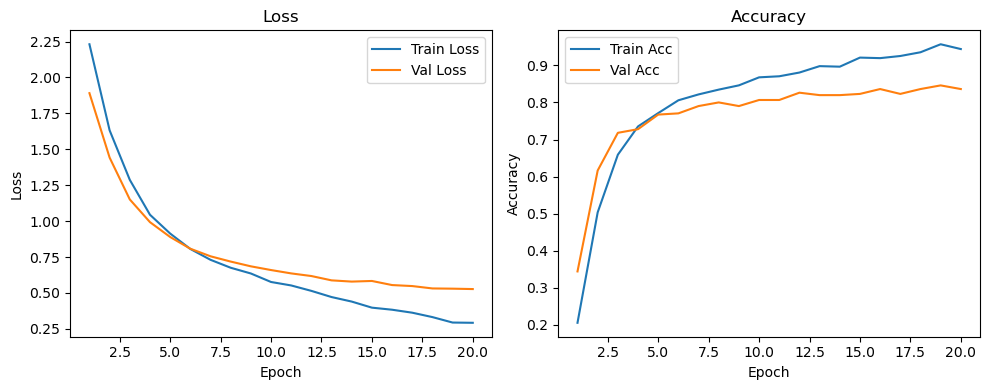

Training curves saved to training_curves.png


In [55]:
try:
    import matplotlib.pyplot as plt

    epochs = list(range(1, len(train_loss_history) + 1))

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_history, label='Train Acc')
    plt.plot(epochs, val_acc_history, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    fig_path = 'training_curves.png'
    plt.tight_layout()
    plt.savefig(fig_path)
    try:
        plt.show()
    except Exception:
        pass
    print(f"Training curves saved to {fig_path}")
except ImportError:
    print('matplotlib not installed; skipping plot generation')

In [56]:
from sklearn.metrics import confusion_matrix, f1_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Collect predictions and probabilities on the test set
model.eval()
all_probs = []
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

if len(all_probs) == 0:
    print('No test predictions collected; skipping sklearn metrics')
else:
    all_probs = np.vstack(all_probs)
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

print(all_probs, all_preds, all_labels)

[[5.24066329e-01 2.59870868e-02 2.62889434e-02 ... 1.25314109e-02
  1.70256291e-02 1.67463478e-02]
 [4.75258827e-01 2.87387669e-02 6.07097074e-02 ... 4.45642695e-02
  9.63584259e-02 3.10595147e-02]
 [9.65351939e-01 7.78091373e-04 4.29109531e-03 ... 1.03330705e-02
  1.85082864e-03 2.81752949e-03]
 ...
 [4.25452255e-02 6.15603775e-02 2.11910591e-01 ... 5.17662428e-02
  2.02132866e-01 1.64789602e-01]
 [1.11032732e-01 7.36901462e-02 1.56602710e-01 ... 5.22430614e-02
  2.64171027e-02 3.29995006e-01]
 [2.16674823e-02 5.06353736e-01 1.35391191e-01 ... 6.54770657e-02
  1.01089716e-01 5.35690263e-02]] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 4, 2, 1, 3, 2, 2, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 6, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 2, 2, 2, 3, 2, 5, 2, 2, 1, 2, 2, 2, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 2, 2, 3, 2, 1, 3, 3, 3, 2, 2, 3, 7, 3, 2, 2, 3, 3, 3, 3, 3, 2, 7, 0, 3, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 

In [57]:
# Weighted F1
try:
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1 (test): {f1:.4f}")
except Exception as e:
    print('Could not compute F1 score:', e)

Weighted F1 (test): 0.8390


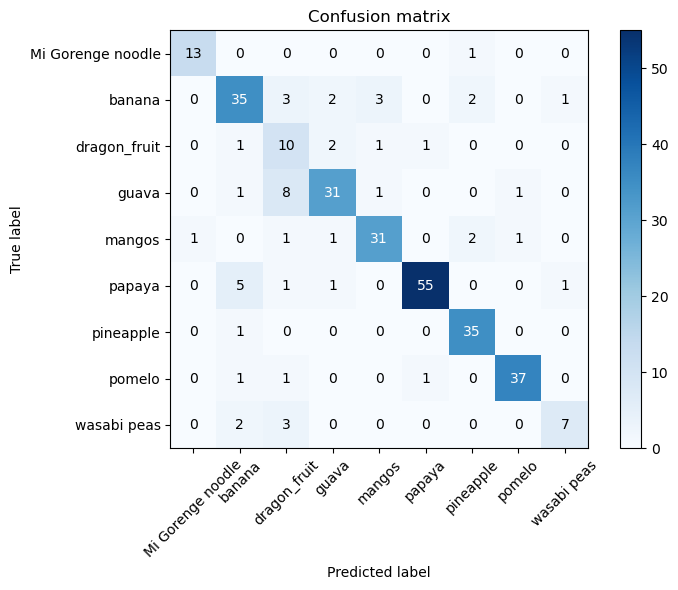

Confusion matrix saved to confusion_matrix.png


In [59]:
# Confusion matrix
try:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    classes = getattr(train_dataset, 'classes', None) or list(range(cm.shape[0]))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # Annotate each cell with the raw count
    thresh = cm.max() / 2. if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(int(cm[i, j]), 'd'),
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')
    plt.show()
    cm_path = 'confusion_matrix.png'
    plt.savefig(cm_path)
    plt.close()
    print(f"Confusion matrix saved to {cm_path}")
except Exception as e:
    print('Could not compute/save confusion matrix:', e)

In [95]:
# --- Helpers for single-image inference (real-world testing) ---
def load_model_checkpoint(model, checkpoint_path, device=None):
    """Load model state_dict from `checkpoint_path` onto `device` and return model.

    Args:
        model: torch.nn.Module instance (architecture must match checkpoint).
        checkpoint_path: path to .pth state_dict file.
        device: torch.device or None (auto-selects CUDA if available).
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model


def predict_image(model, image_path, transform, class_names=None, device=None, topk=3):
    """Run a single image through `model` and return top-k predictions with probabilities.

    Returns a list of tuples: [(class_name_or_idx, prob), ...] sorted by prob desc.
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)
    model.eval()

    img = Image.open(image_path).convert("RGB")
    if transform is not None:
        tensor = transform(img).unsqueeze(0).to(device)
    else:
        # Minimal conversion if no transform provided
        tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)
        top_probs, top_idx = probs.topk(topk, dim=1)

    top_probs = top_probs.cpu().numpy().squeeze()
    top_idx = top_idx.cpu().numpy().squeeze()

    if topk == 1:
        top_probs = [round(float(top_probs),2)]
        top_idx = [int(top_idx)]

    if class_names is not None:
        names = [class_names[i] for i in top_idx]
    else:
        names = [int(i) for i in top_idx]

    img = Image.open(image_path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {preds}")
    plt.show()

    return list(zip(names, [round(float(p),5) for p in top_probs]))

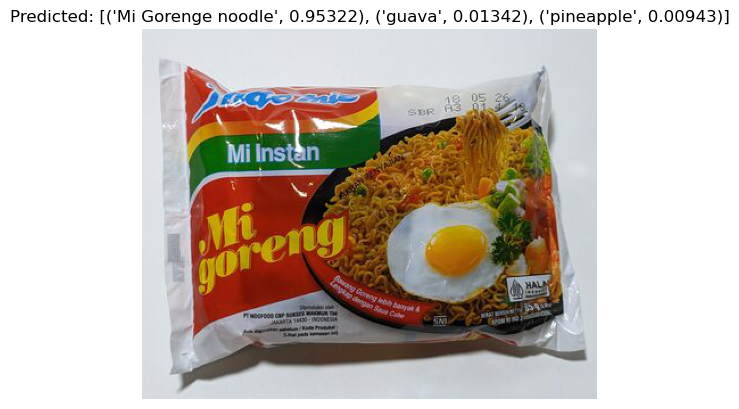

In [96]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.class_to_idx))
model = load_model_checkpoint(model, 'food_resnet18.pth')



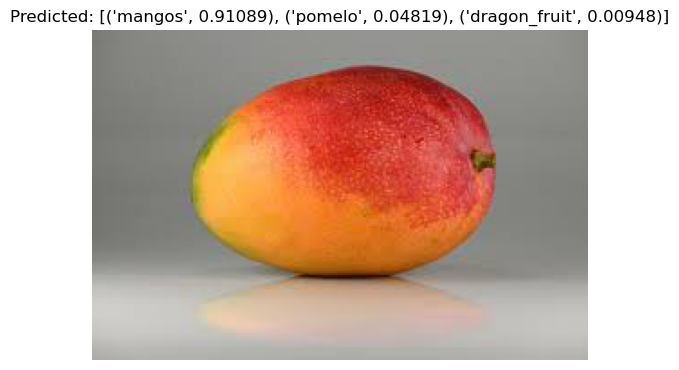

In [100]:
image_path = '/home/licongcong/Downloads/mango.jpeg'
preds = predict_image(model, image_path, transform, class_names=getattr(train_dataset, 'classes', None), topk=3)

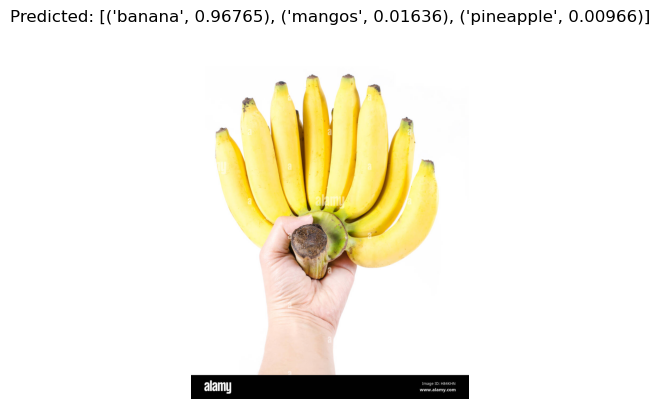

In [105]:
image_path = '/home/licongcong/Downloads/banana.jpeg'
preds = predict_image(model, image_path, transform, class_names=getattr(train_dataset, 'classes', None), topk=3)
